# Credit Card Fraud Detection System

Credit Card Fraud is a common form of theft in the finance sector. Unauthorized and suspicious transaction on bank statements have been an rising issue and these frauds constitute a significant part of the fiscal loss in the banking sector. Detecting a credit card fraud in real time is an uphill task primarily because of the fact that fraud transactions are very few in amount in comparison to the normal transactions. This Notebook follows all basic steps of a Machine Learning Classification lifecycle, and can be used as reference for the few steps involved in construction of a ML pipeline: <br>
1. Loading Data
2. Exploratory Data Analysis: Correlations, Distributions, Outlier detection
3. Feature Scaling: Standard Scaler
4. Data Segmentation
5. Safe Sampling to mitigate class imbalance: Near Miss and SMOTE
6. Model Training: KNN, Logistic Regression, SVM, Logistic-SVM Ensemble with Hard Voting, Tree Based methods, Bagging Classifier, SGD Classifier and Gradient Boosting Methods
7. Predictions and Evaluation
8. Cross Validation: Grid Search CV
9. Model Explanation
10. Forming a sklearn pipeline
11. Serializing the pipeline and dumping it using Joblib
12. Inference Testing

**Objective:** Detecting as many frauds possible and at same time minimizing the number of Non- Frauds categorized as Frauds in the process. <br>
**Challenges:** Class Imbalance, No description available about the features <br>

Git: 

### Imports

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.utils import shuffle

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from lightgbm import record_evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.pipeline import Pipeline
import joblib
import pickle
import json

import random

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### Loading Data

In [2]:
ccfr= pd.read_csv(r'data/creditcard.csv')
ccfr.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


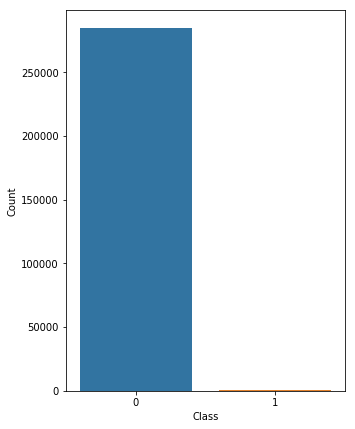

In [3]:
x= ccfr['Class']
plt.figure(figsize=(5,7))
sns.countplot(ccfr['Class'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [4]:
fraud_df= ccfr[ccfr['Class']==1]
nonfraud_df= ccfr[ccfr['Class']==0]
fraudcount= fraud_df.count()[0]
nonfraudcount= nonfraud_df.count()[0]
print ("Frauds=",fraudcount)
print ("Non Frauds=",nonfraudcount)
print (ccfr.shape)

Frauds= 492
Non Frauds= 284315
(284807, 31)


### EDA

Describing the dataframe, we can see that all features are numeric but are not standardised. Hence we will standardise them using a Scaler in further steps.

In [5]:
ccfr.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


There are no missing values in our data:

In [6]:
ccfr.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Plotting the correlation heatmap shows that the independent features donot possess significant inter feature correlation. Hence, all of them can be a feature in our model as they are independent of each other. The pearson correlation indices tell us that the independent variables donot show significant linear relationship with the target variable. Note that the correlation coefficient is a way to represent linear relationships. However, the relationship may be of a higher degree (e.g. tertiary, quadratic and so on) which is not depicted by the correlation coefficient. To visualize such relations, more univariate and multivariate plots need to be checked.

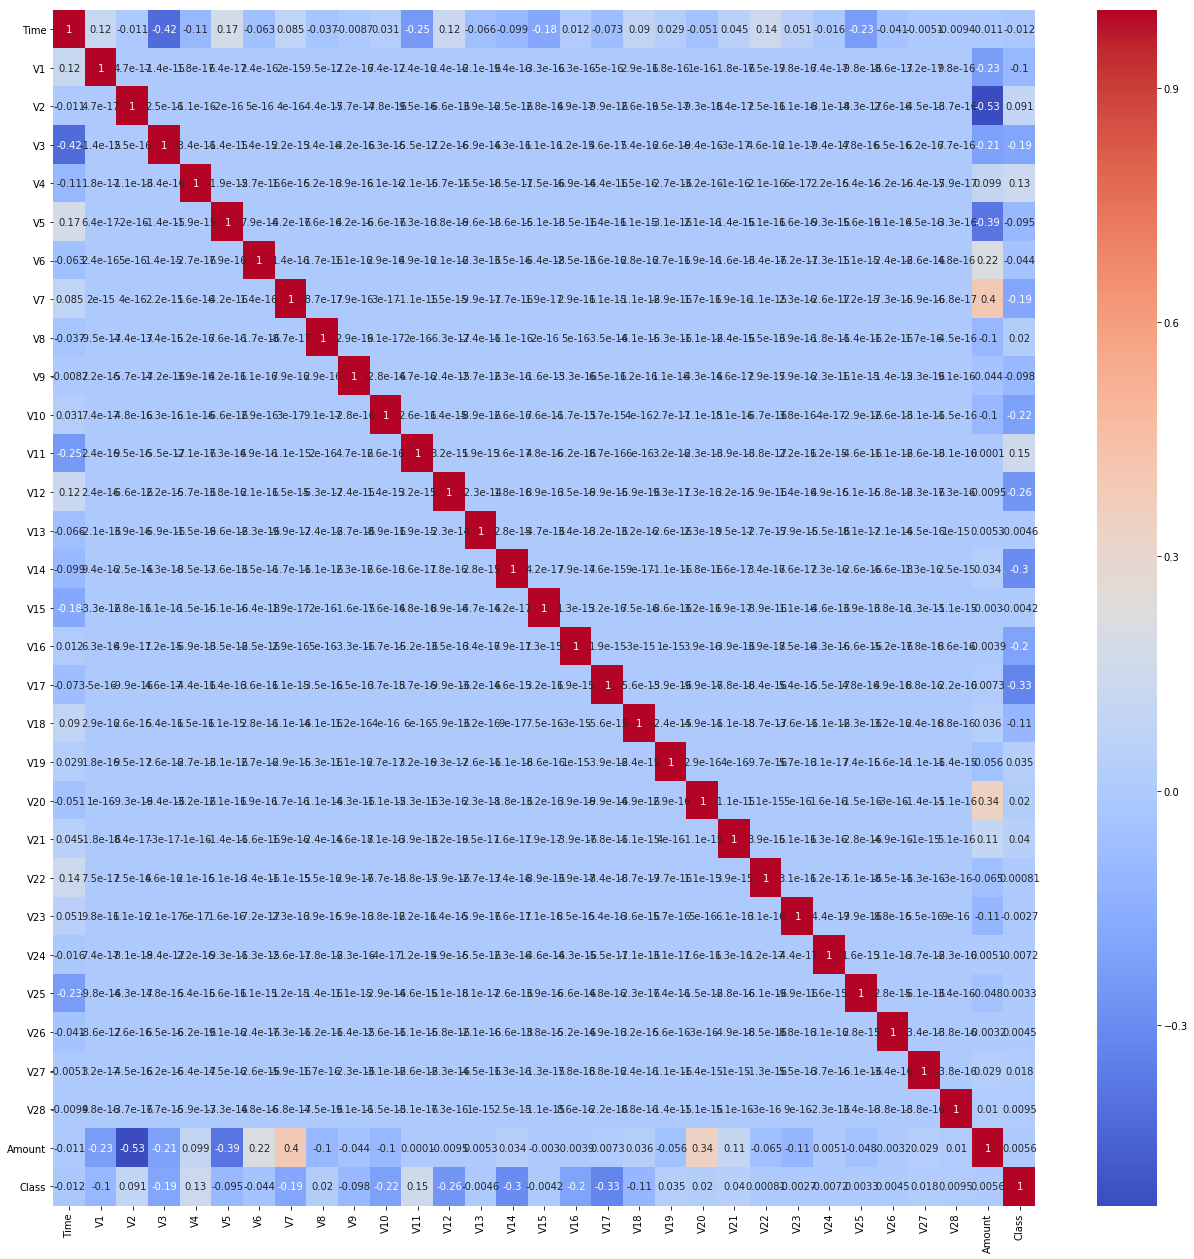

In [7]:
plt.figure(figsize=(22,22))
sns.heatmap(ccfr.corr(),cmap="coolwarm", annot=True)
plt.show()

Let's use seaborn distplot to see the distribution of each feature with respect to the target variable 'Class'. The distplots give us a visual presentation of how a particular feature's values can tell apart among Fraud and Non-fraud cases. The plots showing a clear divide can be considered as significant features that may have good impact on our target variable, which we will cross validate with other measures as well.

******************** COLUMN  Time  ***********************


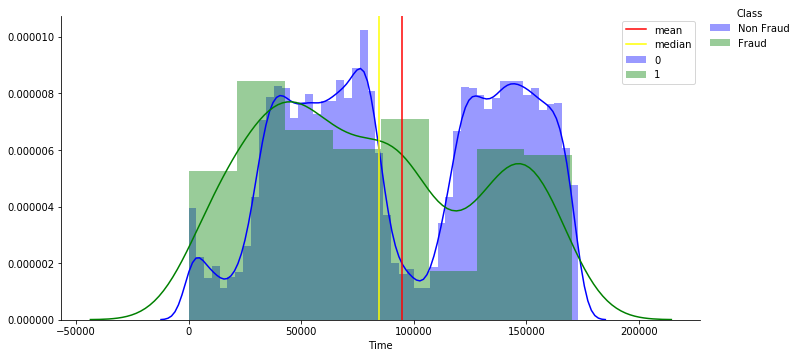

******************** COLUMN  V1  ***********************


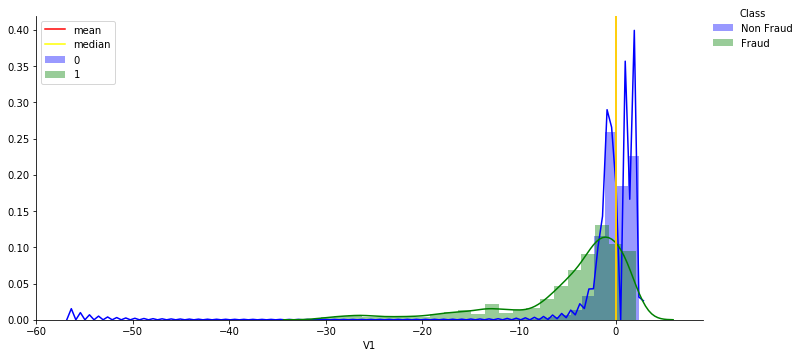

******************** COLUMN  V2  ***********************


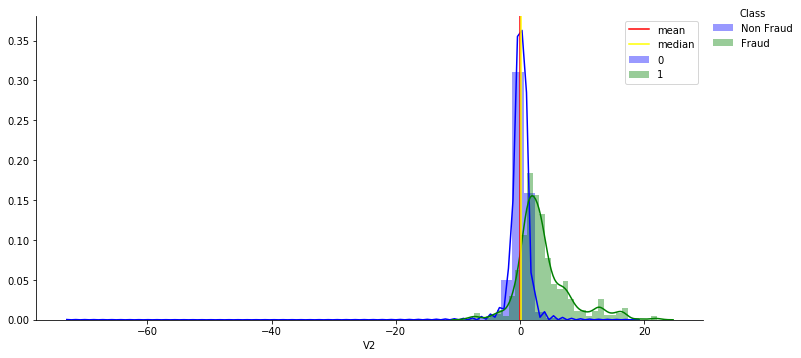

******************** COLUMN  V3  ***********************


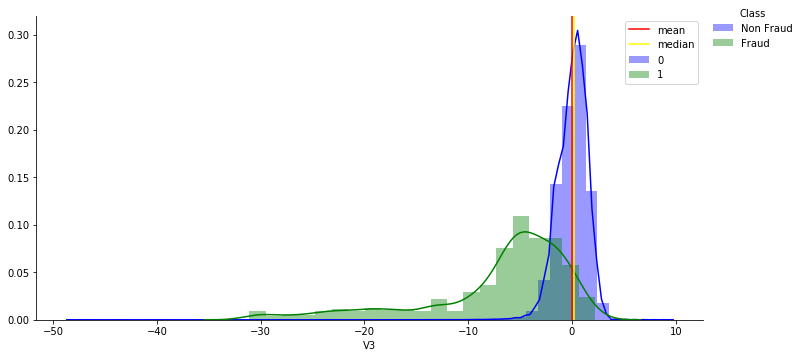

******************** COLUMN  V4  ***********************


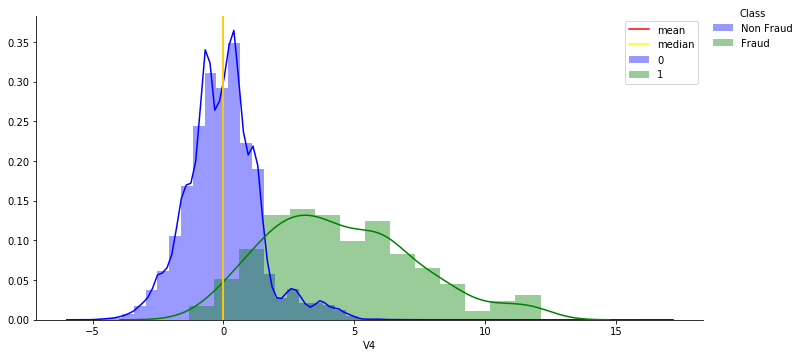

******************** COLUMN  V5  ***********************


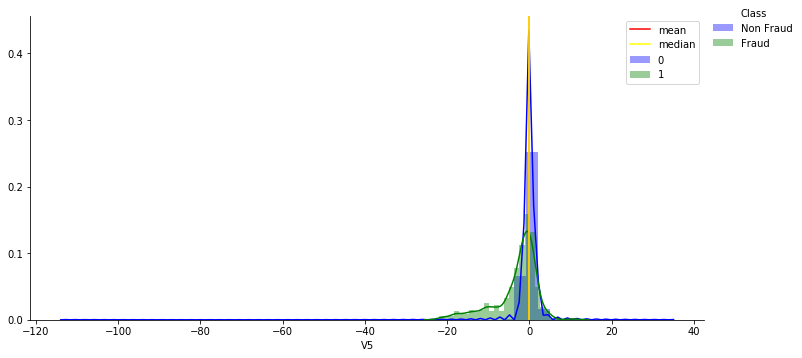

******************** COLUMN  V6  ***********************


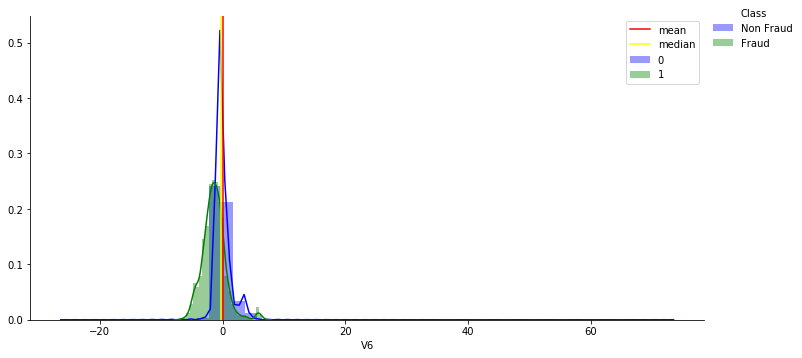

******************** COLUMN  V7  ***********************


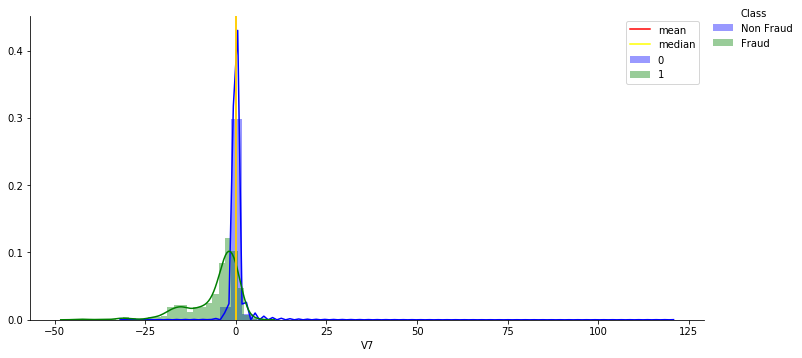

******************** COLUMN  V8  ***********************


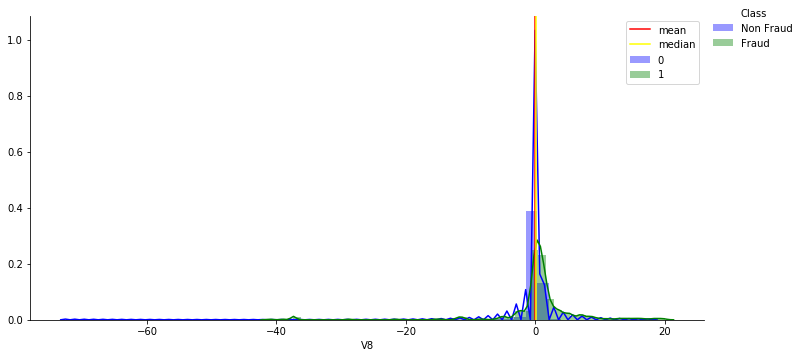

******************** COLUMN  V9  ***********************


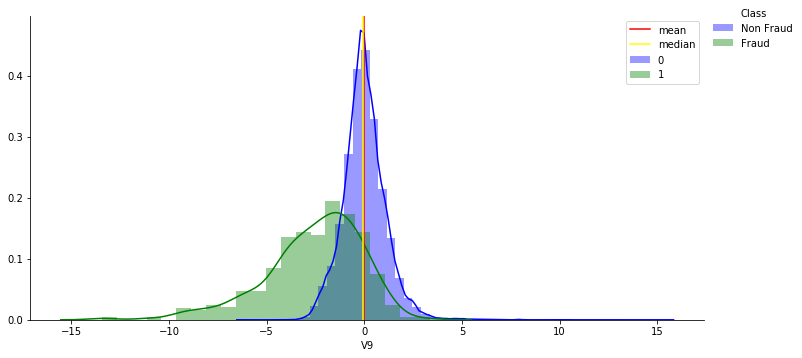

******************** COLUMN  V10  ***********************


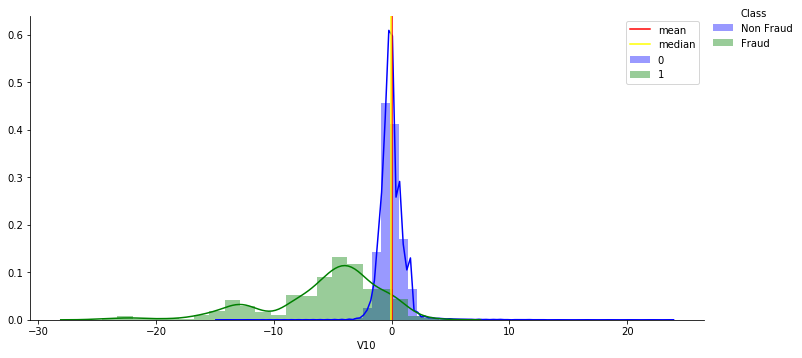

******************** COLUMN  V11  ***********************


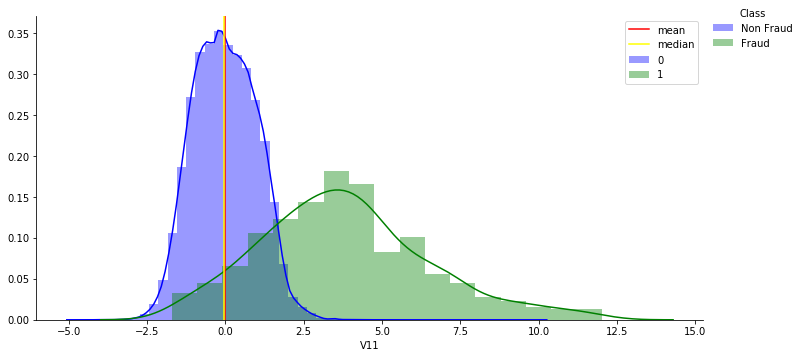

******************** COLUMN  V12  ***********************


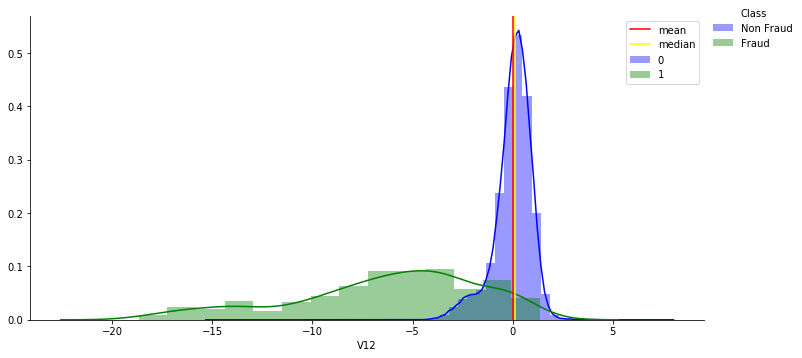

******************** COLUMN  V13  ***********************


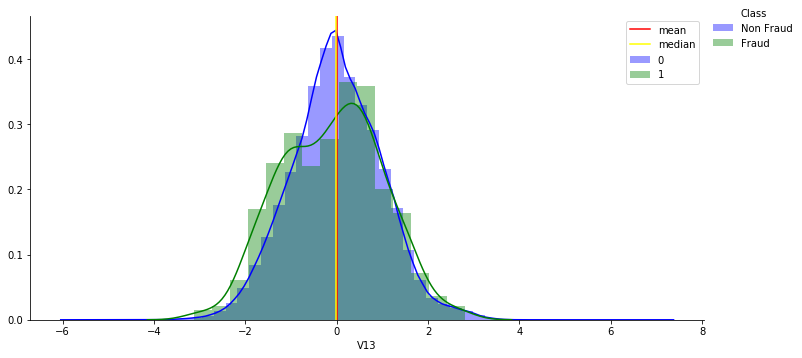

******************** COLUMN  V14  ***********************


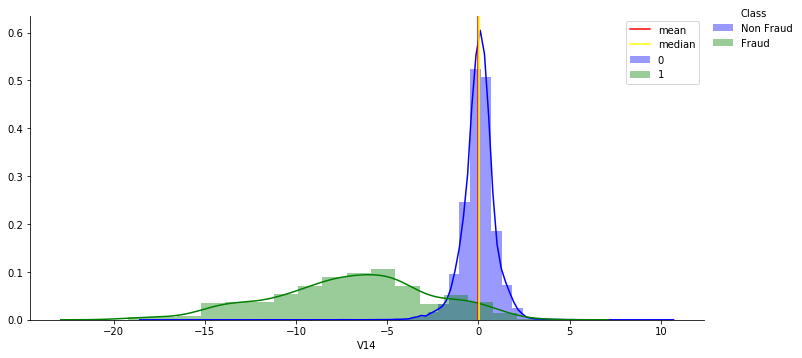

******************** COLUMN  V15  ***********************


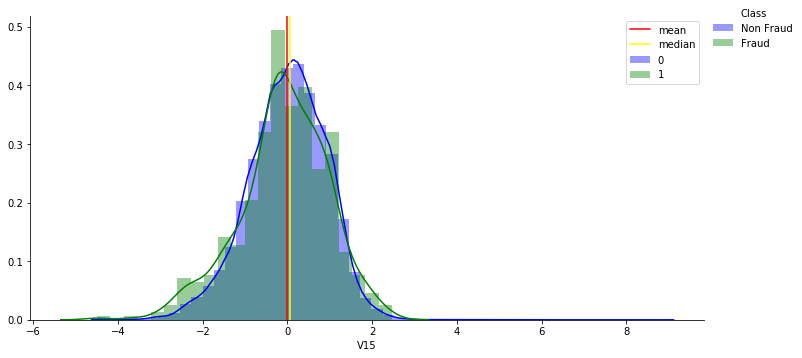

******************** COLUMN  V16  ***********************


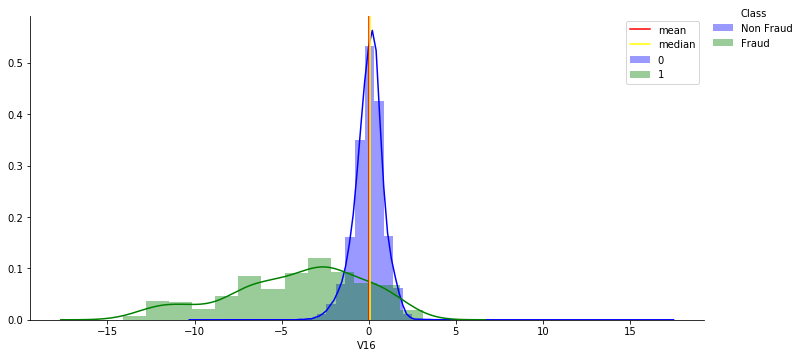

******************** COLUMN  V17  ***********************


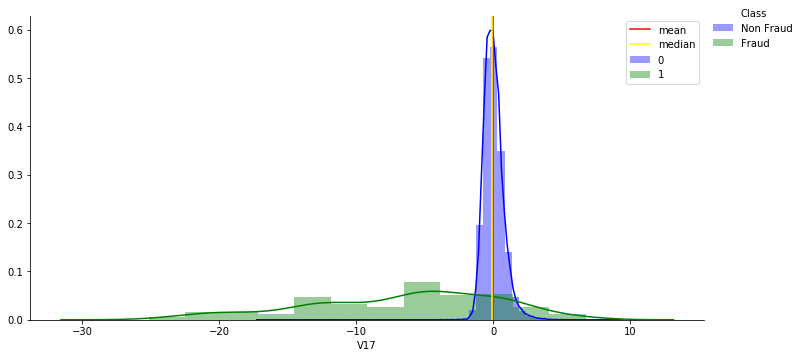

******************** COLUMN  V18  ***********************


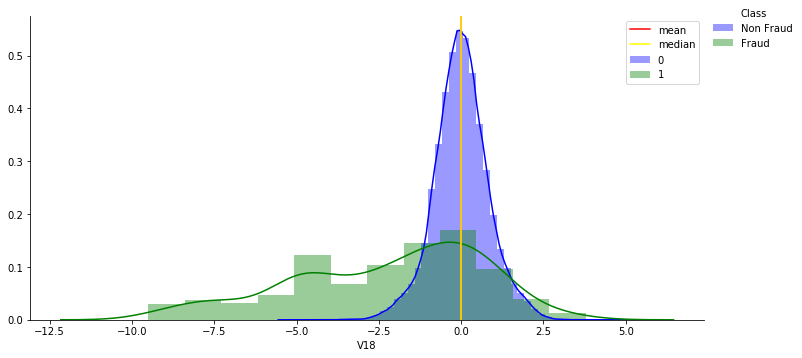

******************** COLUMN  V19  ***********************


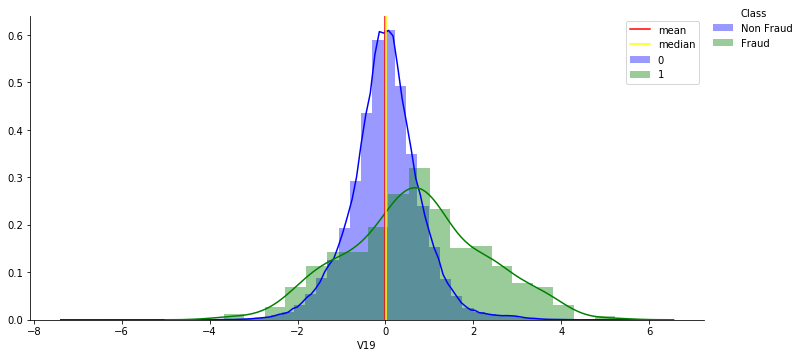

******************** COLUMN  V20  ***********************


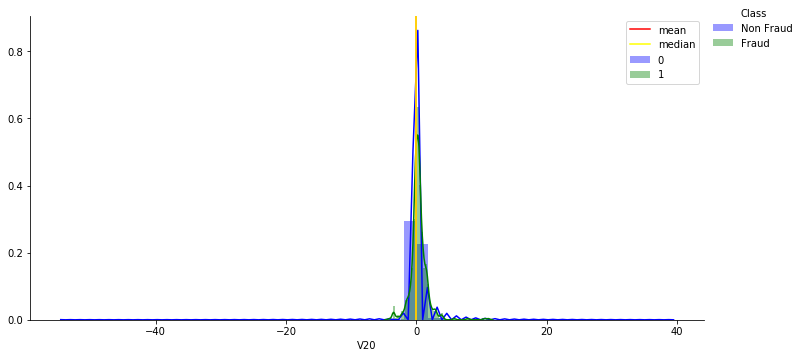

******************** COLUMN  V21  ***********************


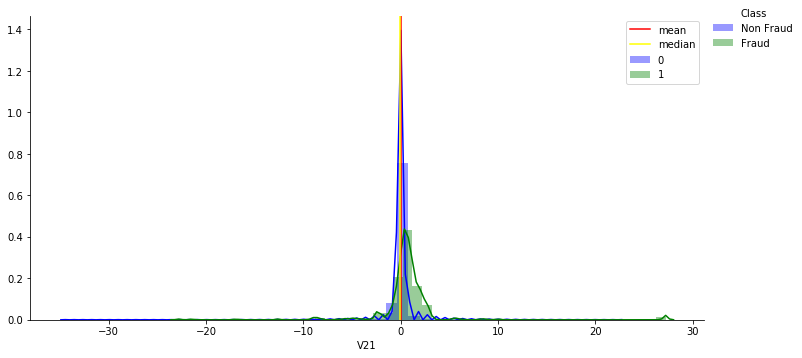

******************** COLUMN  V22  ***********************


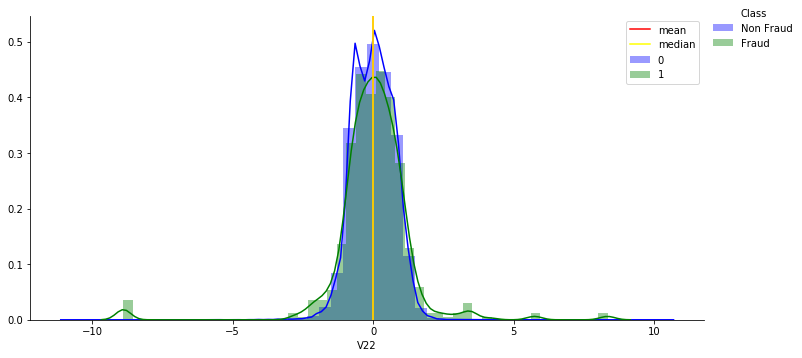

******************** COLUMN  V23  ***********************


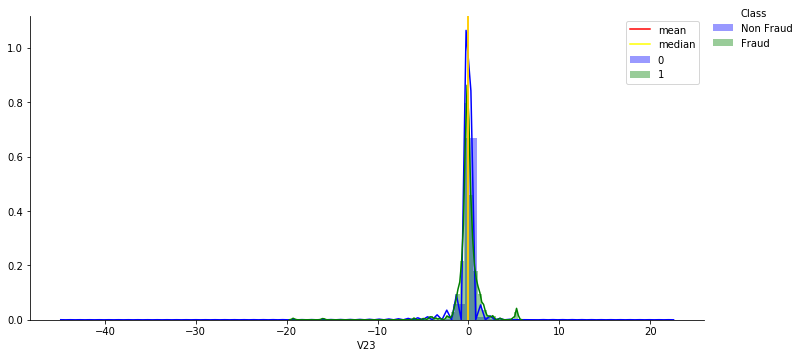

******************** COLUMN  V24  ***********************


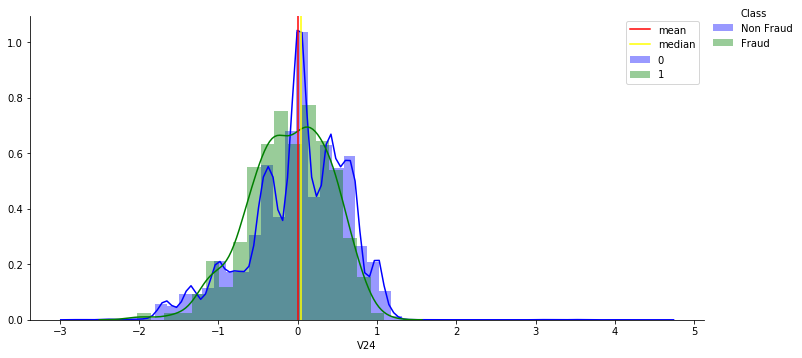

******************** COLUMN  V25  ***********************


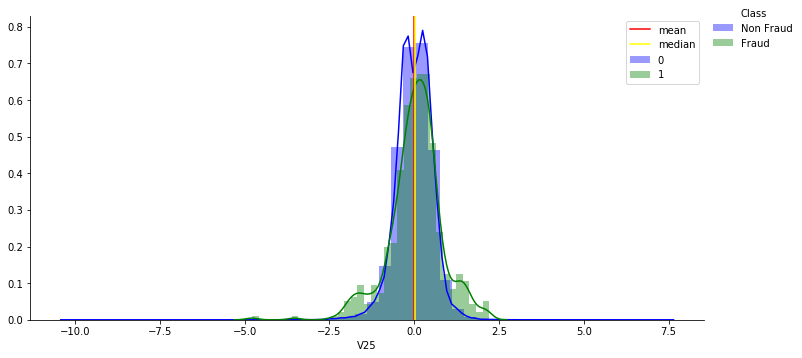

******************** COLUMN  V26  ***********************


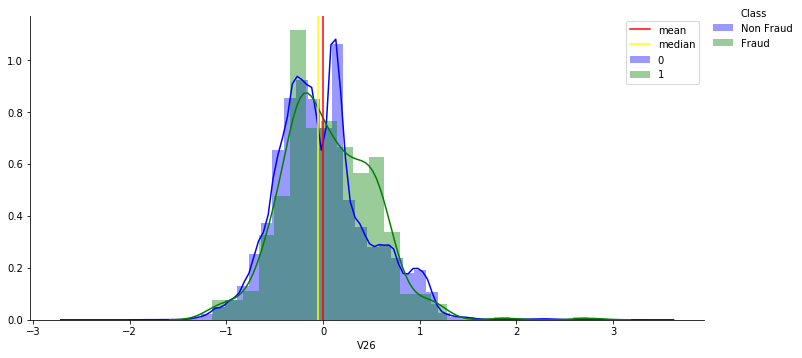

******************** COLUMN  V27  ***********************


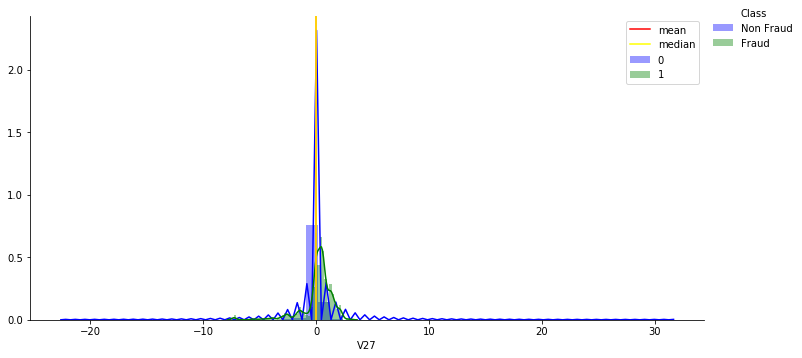

******************** COLUMN  V28  ***********************


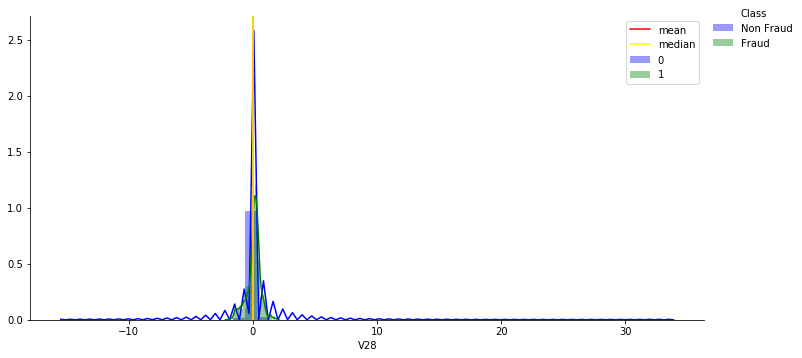

******************** COLUMN  Amount  ***********************


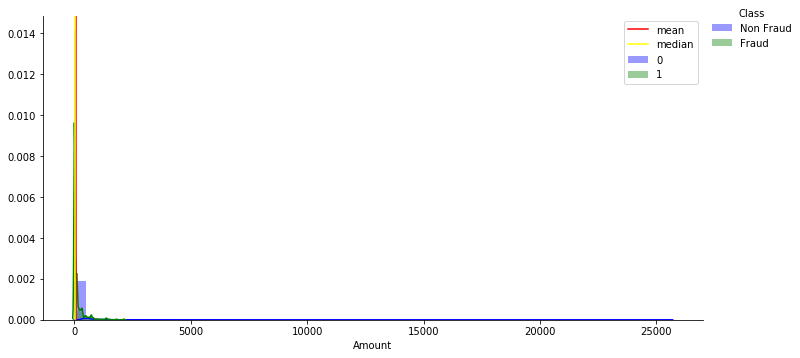

In [8]:
for c in ccfr.columns[0:30]:
    print ("******************** COLUMN ",c," ***********************")
    col= ccfr[c]
    col=np.array(col)
    col_mean= np.mean(col)
    col_median= np.median(col)
    col_std= np.std(col)
    col_var= np.var(col)
    col_range= col.max()-col.min()
    fig=sns.FacetGrid(ccfr,hue="Class",height=5,aspect=2,palette=["blue", "green"])
    fig.map(sns.distplot,c)
    fig.add_legend(labels=['Non Fraud','Fraud'])
    plt.axvline(col_mean,color='red',label='mean')
    plt.axvline(col_median,color='yellow',label='median')
    plt.legend()
    plt.show()

In [9]:
ccfr.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

There are plenty outliers in each feature. However, it is better not removing them as the minority class already has only few samples and there is good chance that these outliers impart some meaning to the problem:

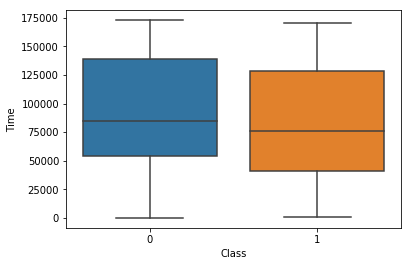

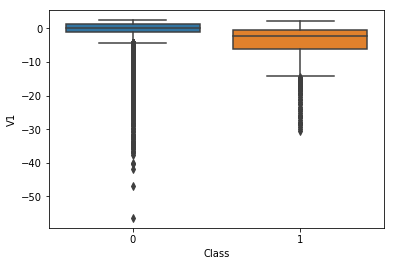

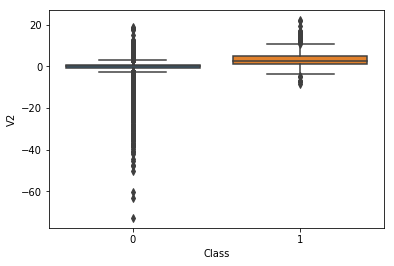

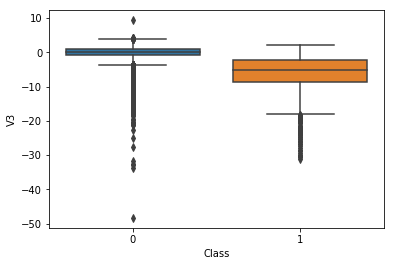

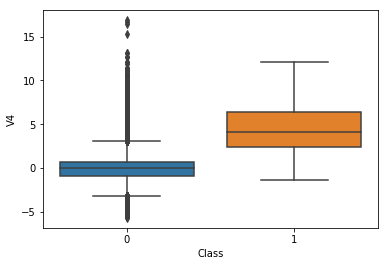

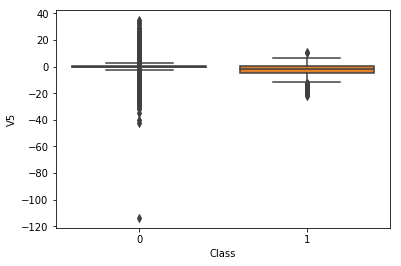

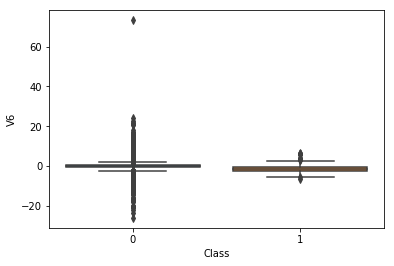

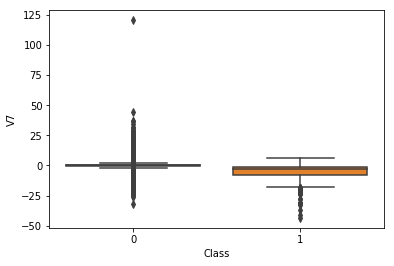

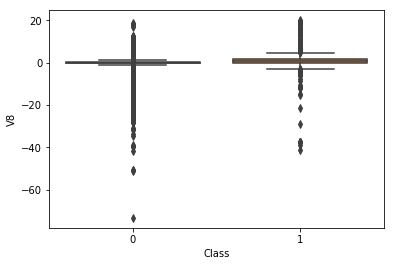

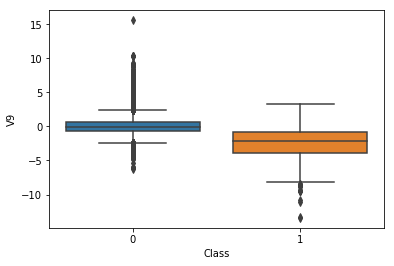

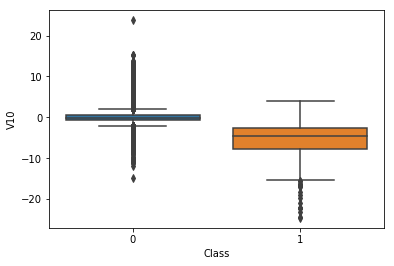

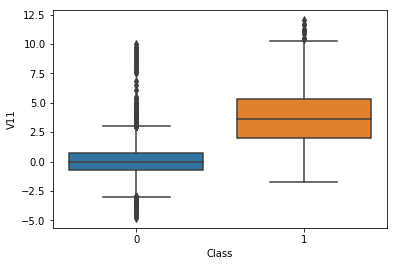

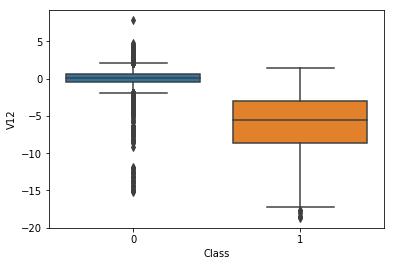

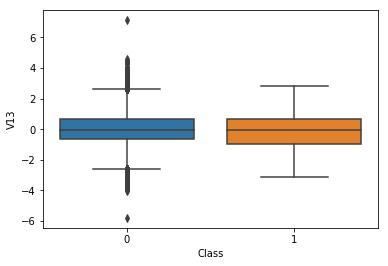

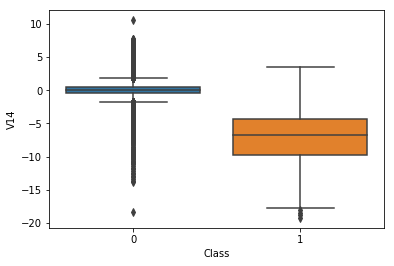

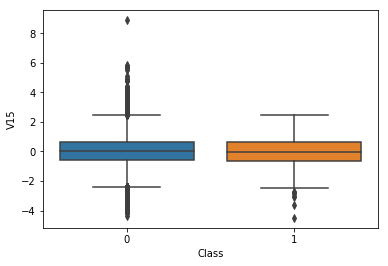

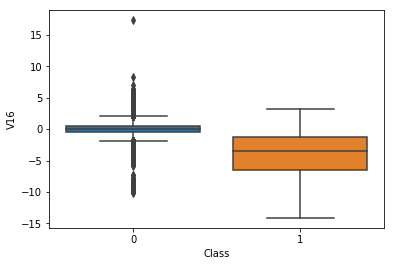

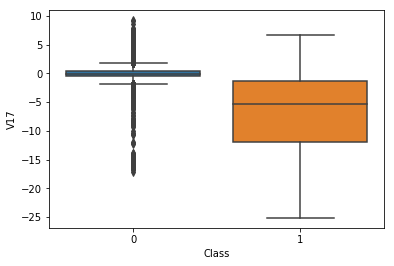

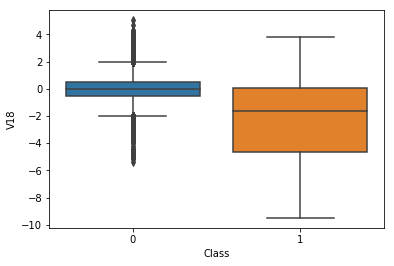

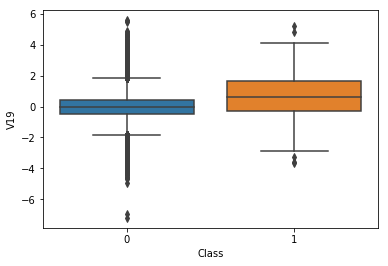

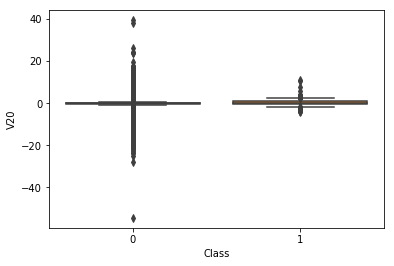

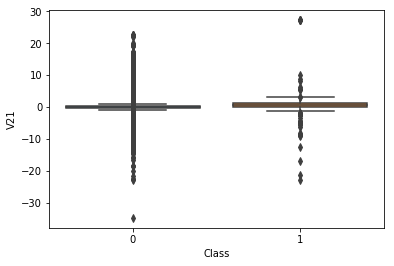

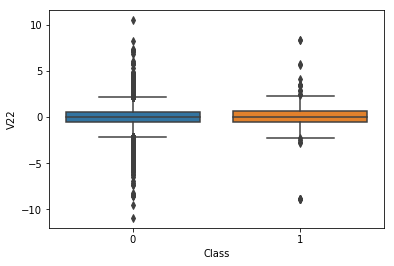

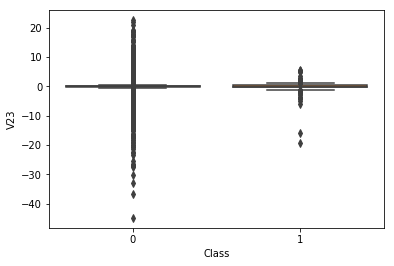

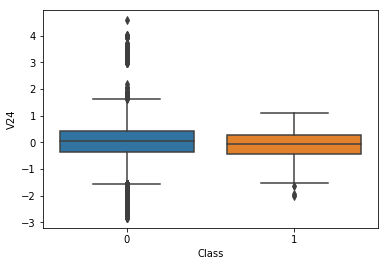

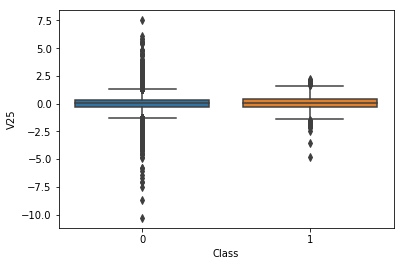

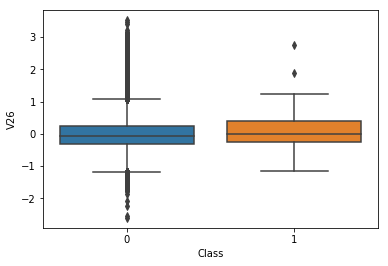

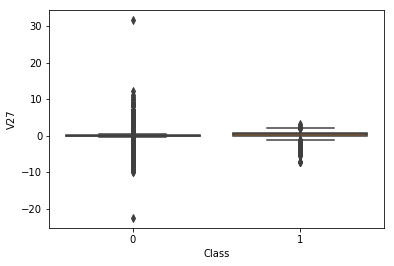

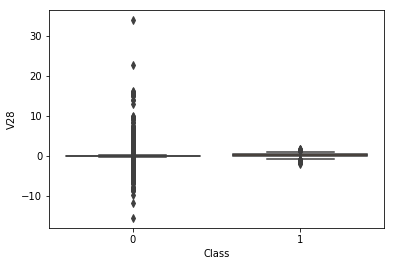

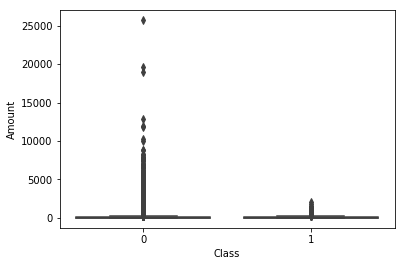

In [10]:
for feature in ccfr.drop('Class', axis= 1).columns:
    sns.boxplot(x='Class', y= feature, data= ccfr)
    plt.show()

### Feature Scaling

Using Sci-kit Learn's Standard Scaler

In [11]:
X = ccfr.drop('Class', axis= 1)
y = ccfr['Class']

In [12]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X.values)
X_scaled = pd.DataFrame(scaled_features, columns= X.columns)

In [13]:
X_scaled.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.996583,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,0.326118,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964
1,-1.996583,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,...,-0.089611,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475
2,-1.996562,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,...,0.680975,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686
3,-1.996562,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,...,-0.269855,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534
4,-1.996541,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,...,0.529939,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403


The features are now standardised and fit for modelling as all of them have mean almost equal to zero and standard deviation nearly equal to 1:

In [14]:
X_scaled.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,-1.050379e-14,-8.157366e-16,3.154853e-17,-4.409878e-15,-6.734811e-16,-2.874435e-16,4.168992e-16,-8.767997e-16,-2.423604e-16,3.078727e-16,...,2.754870e-16,1.685077e-17,1.478472e-15,-6.797197e-16,1.234659e-16,-7.659279e-16,3.247603e-16,-2.953495e-18,5.401572e-17,3.202236e-16
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.996583e+00,-2.879855e+01,-4.403529e+01,-3.187173e+01,-4.013919e+00,-8.240810e+01,-1.963606e+01,-3.520940e+01,-6.130252e+01,-1.222802e+01,...,-7.069146e+01,-4.741907e+01,-1.506565e+01,-7.175446e+01,-4.683638e+00,-1.975033e+01,-5.401098e+00,-5.590660e+01,-4.674612e+01,-3.532294e-01
25%,-8.552120e-01,-4.698918e-01,-3.624707e-01,-5.872142e-01,-5.993788e-01,-5.010686e-01,-5.766822e-01,-4.478860e-01,-1.746805e-01,-5.853631e-01,...,-2.746334e-01,-3.109433e-01,-7.473476e-01,-2.591784e-01,-5.854676e-01,-6.084001e-01,-6.780717e-01,-1.755053e-01,-1.604440e-01,-3.308401e-01
50%,-2.131453e-01,9.245351e-03,3.965683e-02,1.186124e-01,-1.401724e-02,-3.936682e-02,-2.058046e-01,3.241723e-02,1.871982e-02,-4.681169e-02,...,-8.104705e-02,-4.009429e-02,9.345377e-03,-1.792420e-02,6.765678e-02,3.183240e-02,-1.081217e-01,3.325174e-03,3.406368e-02,-2.652715e-01
75%,9.372174e-01,6.716939e-01,4.867202e-01,6.774569e-01,5.250082e-01,4.433465e-01,2.991625e-01,4.611107e-01,2.740785e-01,5.435305e-01,...,1.725733e-01,2.537392e-01,7.283360e-01,2.364319e-01,7.257153e-01,6.728006e-01,4.996663e-01,2.255648e-01,2.371526e-01,-4.471707e-02
max,1.642058e+00,1.253351e+00,1.335775e+01,6.187993e+00,1.191874e+01,2.521413e+01,5.502015e+01,9.747824e+01,1.675153e+01,1.419494e+01,...,5.113464e+01,3.703471e+01,1.447304e+01,3.607668e+01,7.569684e+00,1.442532e+01,7.293975e+00,7.831940e+01,1.025434e+02,1.023622e+02


In [15]:
ccfr_scaled = pd.concat([X_scaled, y], axis= 1)

### Data Segmentation

Train test split. Train set can be used for sampling purposes. The test set is kept aside for "real world" testing.

In [16]:
X = ccfr_scaled.drop('Class', axis= 1)
y = ccfr_scaled['Class']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.13, random_state= 48)

In [18]:
X_train.shape

(247782, 30)

In [19]:
y_train.value_counts()

0    247372
1       410
Name: Class, dtype: int64

In [20]:
y_test.value_counts()

0    36943
1       82
Name: Class, dtype: int64

### Sampling to deal with class imbalance

1. Undersampling the majority class using Near Miss strategy to get the samples from majority class that are nearest to the minority class records in terms of distance. The overall idea is to reduce information loss with undersampling. If our classifier trains on the samples closest to the decision boundary then it will be able to classify points that are farther apart.
2. Oversampling the minority class using SMOTE strategy that is common over sampling used in many class imbalance problems.
3. Aim is to sample to an extent without introducing many systhetic samples of the minority class nor losing out on significant majority class samples. The remaining imbalance can be handled by using class weights in our model parameters when and where required.

In [21]:
train = pd.concat([X_train, y_train], axis =1)

In [22]:
under_sampler = NearMiss(sampling_strategy= {0:100000, 1:410}) 
#under sampling the majority to 80000 records keeping minority as it is
X_train, y_train = under_sampler.fit_sample(X_train, y_train)

In [23]:
over_sampler = SMOTE(sampling_strategy= {0:100000, 1:10000}, random_state= 48)
#over sampling minority class to 20000 records
X_train, y_train = over_sampler.fit_sample(X_train, y_train)

In [24]:
train_sampled = pd.concat([X_train, y_train], axis= 1)
#it is good practice to shuffle the training set
train_sampled = train_sampled.sample(frac=1).reset_index(drop= True)
X_train = train_sampled.drop('Class', axis= 1)
y_train = train_sampled['Class']

In [25]:
X_train.shape

(110000, 30)

In [26]:
y_train.value_counts()

0    100000
1     10000
Name: Class, dtype: int64

In [27]:
X_test.shape

(37025, 30)

In [28]:
y_test.value_counts()

0    36943
1       82
Name: Class, dtype: int64

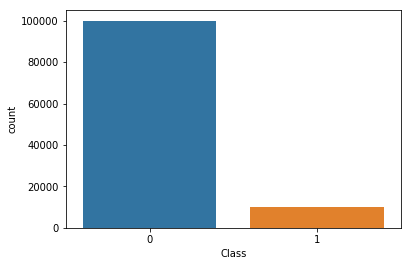

In [29]:
sns.countplot(y_train)
plt.show()

**Post Sampling**<br>
Train Set: (110000, 30) -- 100000 Non Frauds, 10000 Frauds <br>
Test Set: (37025, 30) -- 36943 Non Frauds, 82 Frauds

### Model Training and Evaluation 
The motive of our classifier will be to predict maximum of the fraud transactions as fraud at the cost of some non fraud transactions being predicted as fraud. But we must not lose out on the fraud transactions! Hence we will aim for High recall on the frauds (that is the percentage of frauds correctly classified as frauds) but a low precision on the frauds is manageable. Thus, a good overall ROC Score and good recall score for the minority class will be apt.

**KNN Classifier**

In [30]:
knn_model = KNeighborsClassifier(n_neighbors= 4, n_jobs= -1)
knn_model.fit(X_train, y_train)
pred = knn_model.predict(X_test)
print ("ROC AUC Score=",roc_auc_score(y_test, pred))
print ("Classification Report:")
print (classification_report(y_test, pred))

ROC AUC Score= 0.9530473115141783
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     36943
           1       0.09      0.93      0.16        82

    accuracy                           0.98     37025
   macro avg       0.55      0.95      0.58     37025
weighted avg       1.00      0.98      0.99     37025



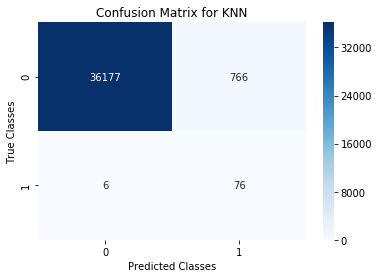

In [31]:
cm = pd.DataFrame(confusion_matrix(y_test, pred))
plt.figure()
plt.title("Confusion Matrix for KNN")
sns.heatmap(cm, cmap= "Blues", annot= True, fmt= "d")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

Hence, with KNN Classifier we are able to predict 93% (76 out of 82) Frauds correctly at a cost of 2% (766 out of 36943) of the Non Frauds being predicted as Frauds.

**Logistic Regression**

In [32]:
lr_model= LogisticRegression(solver= 'liblinear')
lr_model.fit(X_train,y_train)
pred = lr_model.predict(X_test)
print ("ROC AUC Score=",roc_auc_score(y_test, pred))
print ("Classification Report:")
print (classification_report(y_test, pred))

ROC AUC Score= 0.9458405929239704
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     36943
           1       0.04      0.94      0.08        82

    accuracy                           0.95     37025
   macro avg       0.52      0.95      0.53     37025
weighted avg       1.00      0.95      0.97     37025



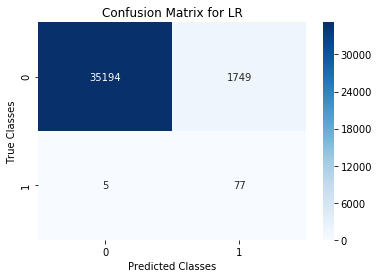

In [33]:
cm = pd.DataFrame(confusion_matrix(y_test, pred))
plt.figure()
plt.title("Confusion Matrix for LR")
sns.heatmap(cm, cmap= "Blues", annot= True, fmt= "d")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

Hence, with Logistic Regression we are able to predict 94% (77 out of 82) Frauds correctly at a cost of 5% (1749 out of 36943) of the Non Frauds being predicted as Frauds.

**SVM Classifier**

In [34]:
svc_model = svm.SVC(kernel='rbf', gamma= 0.03, C= 1.0)
svc_model.fit(X_train, y_train)
pred= svc_model.predict(X_test)

In [35]:
print ("ROC AUC Score=",roc_auc_score(y_test, pred))
print ("Classification Report:")
print (classification_report(y_test, pred))

ROC AUC Score= 0.9635235692692037
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     36943
           1       0.08      0.95      0.15        82

    accuracy                           0.98     37025
   macro avg       0.54      0.96      0.57     37025
weighted avg       1.00      0.98      0.99     37025



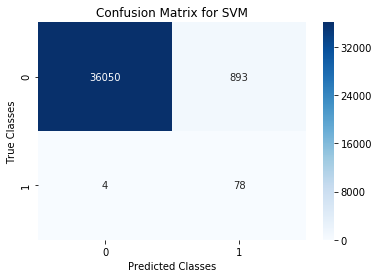

In [37]:
cm = pd.DataFrame(confusion_matrix(y_test, pred))
plt.figure()
plt.title("Confusion Matrix for SVM")
sns.heatmap(cm, cmap= "Blues", annot= True, fmt= "d")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

Hence, Support Vector Classifier does great and is able to predict 95% (78 out of 82) Frauds correctly at a cost of 2% (893 out of 36943) of the Non Frauds being predicted as Frauds.

**Logistic Regression + KNN Voting CLassifier**

Voting Classifier combines predictions on the data set from two different classifiers and votes on the best prediction. Voting Classifier is a good means to combine predictions from two similar kind of classifiers and bring out the best parts of both the classifiers and combine them. We can see that KNN Classifier predicted 93% frauds compared to the 94% predicted by Logistic Regression. However, KNN predicted lesser no. of Non- Frauds as Frauds as compared to Logistic. (KNN predicted 766 non frauds as frauds compared to 1749 in case of LR.) So we will try and combine LR and KNN to see if we can get a better combination of results.

In [38]:
voting_clf_hard = VotingClassifier(estimators = [('lr', lr_model), ('knn', knn_model)], voting = 'hard')
voting_clf_hard.fit(X_train, y_train)
pred= voting_clf_hard.predict(X_test)
print ("ROC AUC Score=",roc_auc_score(y_test, pred))
print ("Classification Report:")
print (classification_report(y_test, pred))

ROC AUC Score= 0.948384393096022
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     36943
           1       0.10      0.91      0.18        82

    accuracy                           0.98     37025
   macro avg       0.55      0.95      0.59     37025
weighted avg       1.00      0.98      0.99     37025



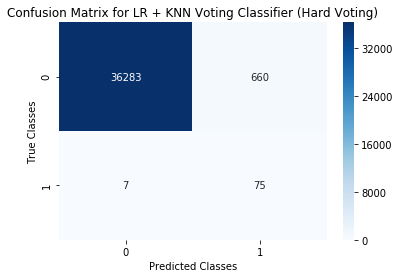

In [39]:
cm = pd.DataFrame(confusion_matrix(y_test, pred))
plt.figure()
plt.title("Confusion Matrix for LR + KNN Voting Classifier (Hard Voting)")
sns.heatmap(cm, cmap= "Blues", annot= True, fmt= "d")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

The Hard voting classifier using LR and KNN gets 91% of Fraud predictions right at a reduced cost of just 2% (660 of 36943) of Non frauds getting classified as fraud. It reduces the no. of Non Frauds misclassified, but also hinders the fraud detection %. So, we will change the voting mechanism to Soft voting and provide weights to give more weights to probability calculated by the LR model:

In [44]:
voting_clf_soft = VotingClassifier(estimators = [('lr', lr_model), ('knn', knn_model)], voting = 'soft',
                                  weights= [0.7, 0.3])
voting_clf_soft.fit(X_train, y_train)
pred= voting_clf_soft.predict(X_test)
print ("ROC AUC Score=",roc_auc_score(y_test, pred))
print ("Classification Report:")
print (classification_report(y_test, pred))

ROC AUC Score= 0.9501309862325811
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     36943
           1       0.05      0.94      0.10        82

    accuracy                           0.96     37025
   macro avg       0.53      0.95      0.54     37025
weighted avg       1.00      0.96      0.98     37025



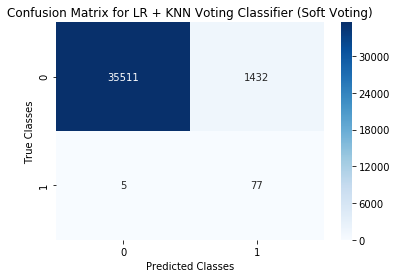

In [45]:
cm = pd.DataFrame(confusion_matrix(y_test, pred))
plt.figure()
plt.title("Confusion Matrix for LR + KNN Voting Classifier (Soft Voting)")
sns.heatmap(cm, cmap= "Blues", annot= True, fmt= "d")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

The Soft Voting Classifier helps us combine the classifiers well. We have retained the better fraud detection % of the Logistic regression model i.e. 94% (77 of 82). We also managed to decrease the number of Non frauds misclassified as Frauds. (1432 of 36943)

**Decision Tree Classifier**

In [46]:
dctree_model = DecisionTreeClassifier(random_state=0)
dctree_model.fit(X_train, y_train)
pred= dctree_model.predict(X_test)
print ("ROC AUC Score=",roc_auc_score(y_test, pred))
print ("Classification Report:")
print (classification_report(y_test, pred))

ROC AUC Score= 0.9287389340071025
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     36943
           1       0.04      0.90      0.08        82

    accuracy                           0.95     37025
   macro avg       0.52      0.93      0.53     37025
weighted avg       1.00      0.95      0.97     37025



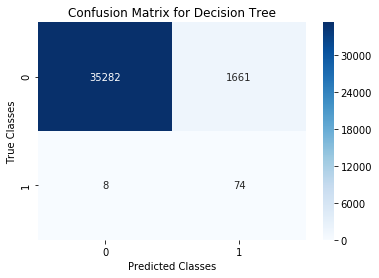

In [47]:
cm = pd.DataFrame(confusion_matrix(y_test, pred))
plt.figure()
plt.title("Confusion Matrix for Decision Tree")
sns.heatmap(cm, cmap= "Blues", annot= True, fmt= "d")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

Decision Tree classifier detects 90% of the frauds. We can do better by using the ensemble tree based approaches.

**SGD Clasifier**

SGD Classifier comes with set of hyperparameters that can be set accordingly to train linear models like Logistic regression or SVMs while minimizing the loss using Stochastic Gradient Descent. SGD Classifier models do good on large sized data.

In [48]:
sgd_model = SGDClassifier(class_weight = 'balanced', learning_rate = 'adaptive', n_jobs = -1, eta0 = 0.001, 
                          max_iter = 100000)
sgd_model.fit(X_train, y_train)
pred = sgd_model.predict(X_test)
print ("ROC AUC Score=",roc_auc_score(y_test, pred))
print ("Classification Report:")
print (classification_report(y_test, pred))

ROC AUC Score= 0.9242803514709212
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     36943
           1       0.02      0.94      0.04        82

    accuracy                           0.91     37025
   macro avg       0.51      0.92      0.50     37025
weighted avg       1.00      0.91      0.95     37025



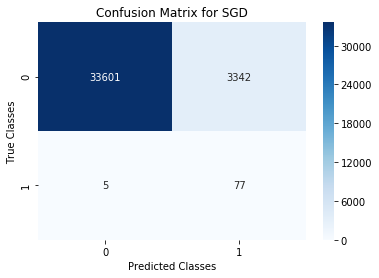

In [49]:
cm = pd.DataFrame(confusion_matrix(y_test, pred))
plt.figure()
plt.title("Confusion Matrix for SGD")
sns.heatmap(cm, cmap= "Blues", annot= True, fmt= "d")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

Stochastic Gradient Descent Classifier detects 94% of the fraud cases but at a cost of 9% of Non Frauds being predicted as Fraud.

**Bagging Classifier using Decision Tree**

A Bagging Classifier can be used to build an ensemble of a number of similar model. Here we will build an ensemble by bagging 1000 Decision Tree Classifiers that we built earlier. RandomForest is an example of pre- available Bagging Tree classifiers present in Scikit Learn.

In [52]:
bagging_clf = BaggingClassifier(DecisionTreeClassifier(random_state = 0), n_estimators = 1000, bootstrap = True,
                               max_samples = 0.85, n_jobs = -1, oob_score = True)
#bootsrap True signifies sampling (max_samples) from the data without replacement for each estimator
#oob_score True enables training on set of samples chosen and test on the out-of-bag samples(samples not chosen for training)
bagging_clf.fit(X_train, y_train)
pred = bagging_clf.predict(X_test)
print ("ROC AUC Score=",roc_auc_score(y_test, pred))
print ("Classification Report:")
print (classification_report(y_test, pred))

ROC AUC Score= 0.9585358261210579
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     36943
           1       0.09      0.94      0.16        82

    accuracy                           0.98     37025
   macro avg       0.54      0.96      0.57     37025
weighted avg       1.00      0.98      0.99     37025



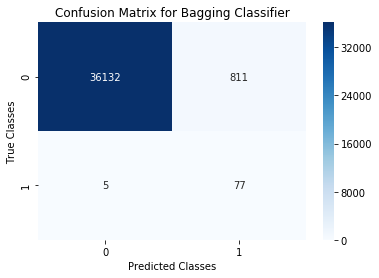

In [53]:
cm = pd.DataFrame(confusion_matrix(y_test, pred))
plt.figure()
plt.title("Confusion Matrix for Bagging Classifier")
sns.heatmap(cm, cmap= "Blues", annot= True, fmt= "d")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

By using the Decision tree in a bagging classifier, the performance has improved significantly. The fraud prediction rate is now 94% compared to 90% achieved with decision trees classifier.

**LightGBM**<br>
LightGBM is a gradient boosting framework that is new and has been growing fast in terms of popularity. It promises great results similar to XGBoost and that to at extremely lesser training time. We will train the LightGBM model and track it's evaluation history using the eval_history callback to know the right no. of estimators to stop at. The evaluation metric chosen for the purpose is the roc auc score.

In [60]:
lgb_model = LGBMClassifier(boosting_type = 'gbdt', num_leaves = 32, max_depth = 7, learning_rate = 0.007, 
                           n_estimators = 3500, objective = 'binary', min_split_gain = 0.1, min_child_weight = 0.01,
                           class_weight= {0:0.2, 1:1},
                           min_child_samples = 20, subsample=0.6, colsample_bytree = 0.8, reg_alpha = 0.3, reg_lambda = 0.7,
                           n_jobs = -1, verbose = -1)
history = {}
eval_history = record_evaluation(history)
lgb_model.fit(X_train, y_train,
             eval_set = [(X_train, y_train), (X_test, y_test)],
             eval_metric = 'auc', verbose = 500,
             callbacks = [eval_history])
pred = lgb_model.predict(X_test)
print ("ROC AUC Score=",roc_auc_score(y_test, pred))
print ("Classification Report:")
print (classification_report(y_test, pred))

[500]	training's auc: 0.9996	training's binary_logloss: 0.0472086	valid_1's auc: 0.995233	valid_1's binary_logloss: 0.0614661
[1000]	training's auc: 0.999934	training's binary_logloss: 0.0166978	valid_1's auc: 0.995887	valid_1's binary_logloss: 0.0344338
[1500]	training's auc: 0.999981	training's binary_logloss: 0.00745895	valid_1's auc: 0.995868	valid_1's binary_logloss: 0.0249829
[2000]	training's auc: 0.999991	training's binary_logloss: 0.00409954	valid_1's auc: 0.995715	valid_1's binary_logloss: 0.0210382
[2500]	training's auc: 0.999997	training's binary_logloss: 0.00265923	valid_1's auc: 0.995631	valid_1's binary_logloss: 0.0197351
[3000]	training's auc: 0.999997	training's binary_logloss: 0.00252344	valid_1's auc: 0.995538	valid_1's binary_logloss: 0.0195915
[3500]	training's auc: 0.999997	training's binary_logloss: 0.00252344	valid_1's auc: 0.995538	valid_1's binary_logloss: 0.0195915
ROC AUC Score= 0.9660067949108151
Classification Report:
              precision    recall  f1-

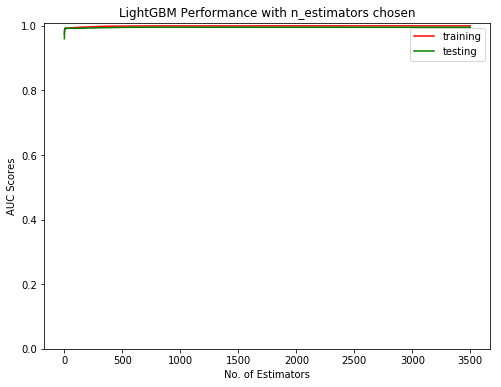

In [61]:
train_aucs = history['training']['auc']
test_aucs = history['valid_1']['auc']
plt.figure(figsize = (8,6))
plt.ylim([0,1.01])
plt.plot(train_aucs, color= 'r', label= 'training')
plt.plot(test_aucs, color= 'g', label= 'testing')
plt.xlabel("No. of Estimators")
plt.ylabel('AUC Scores')
plt.legend(loc= 'best')
plt.title("LightGBM Performance with n_estimators chosen")
plt.show()

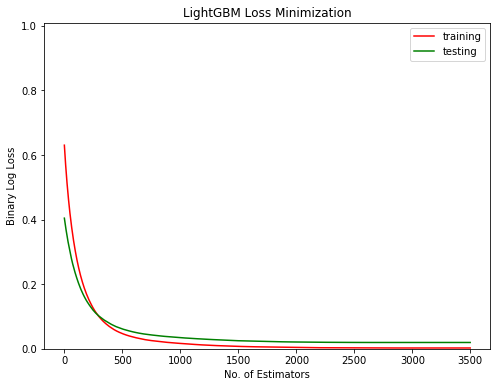

In [62]:
train_logloss = history['training']['binary_logloss']
test_logloss = history['valid_1']['binary_logloss']
plt.figure(figsize = (8,6))
plt.ylim([0,1.01])
plt.plot(train_logloss, color= 'r', label= 'training')
plt.plot(test_logloss, color= 'g', label= 'testing')
plt.xlabel("No. of Estimators")
plt.ylabel('Binary Log Loss')
plt.legend(loc= 'best')
plt.title("LightGBM Loss Minimization")
plt.show()

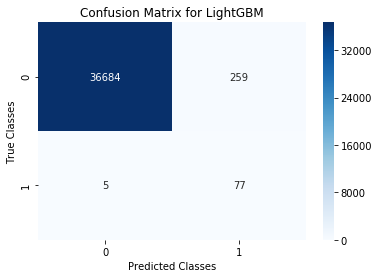

In [63]:
cm = pd.DataFrame(confusion_matrix(y_test, pred))
plt.figure()
plt.title("Confusion Matrix for LightGBM")
sns.heatmap(cm, cmap= "Blues", annot= True, fmt= "d")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

LightGBM gives best overall performance by predicting 94% of the frauds at the cost of just 259 non frauds getting classified as frauds.

**Evaluating LightGBM with K Fold CV**

Let's see if KFold CV can help us run more estimators without overfitting on the train set and evaluate the predictions on the test set! <br>
**Note:** KFold CV is more of an evaluation method to check if our classifier doesnot overfit on the training set and has good overall prediction on different testing samples. A KFold CV operation should be done on the parent data and not on the sampled set. The sampling should be done within the CV after attaining the train test split for each fold. Using sampled data for KFold splits in the Cross validation will not suffice the "real world" testing. <br>
**Note 2:** For sampling the data splits during each Fold of the process, use the same sampling method used before training phase of the model. In this case it is Near Miss + Smote

In [101]:
lgb_model = LGBMClassifier(boosting_type = 'gbdt', num_leaves = 30, max_depth = 7, learning_rate = 0.007, 
                           n_estimators = 4500, objective = 'binary', min_split_gain = 0.1, min_child_weight = 0.01,
                           class_weight= {0:0.2, 1:1},
                           min_child_samples = 20, subsample=0.6, colsample_bytree = 0.8, reg_alpha = 0.3, reg_lambda = 0.7,
                           n_jobs = -1, verbose = -1)

cv = KFold(n_splits = 10, random_state = 48, shuffle = True)

TP = 0 #TruePositives
TN = 0 #TrueNegatives
FP = 0 #FalsePositives
FN = 0 #FalseNegatives
roc_auc_scores = []

x1 = X #taking the original scaled data post train test split
y1 = y

for train_ind, test_ind in cv.split(x1):
    xtrain, xtest, ytrain, ytest= x1.loc[list(train_ind)], x1.loc[list(test_ind)], y1.loc[list(train_ind)], y1.loc[list(test_ind)]
    
    under_sampler_cv = NearMiss(sampling_strategy= {0:100000, 1:410}) 
    xtrain, ytrain = under_sampler_cv.fit_sample(xtrain, ytrain)
    
    over_sampler_cv = SMOTE(sampling_strategy= {0:100000, 1:10000}, random_state= 48)
    xtrain, ytrain = over_sampler_cv.fit_sample(xtrain, ytrain)
    
    train_set = pd.concat([xtrain, ytrain], axis= 1)
    train_set = train_set.sample(frac=1).reset_index(drop= True)
    xtrain = train_set.drop('Class', axis= 1)
    ytrain = train_set['Class']
    
    lgb_model.fit(xtrain, ytrain)
    prd = lgb_model.predict(xtest)
    true = np.array(ytest)
    l = len(prd)
    for i in range (l):
        if true[i]==1 and prd[i]==1:
            TP+=1
        if true[i]==1 and prd[i]==0:
            FN+=1
        if true[i]==0 and prd[i]==1:
            FP+=1
        if true[i]==0 and prd[i]==0:
            TN+=1
    roc_auc_scores.append(roc_auc_score(true, prd))

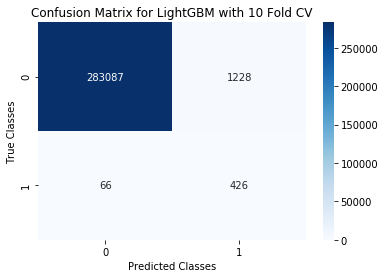

In [103]:
cm = pd.DataFrame([[TN, FP], [FN, TP]], index= [0,1], columns= [0,1])
plt.figure()
plt.title("Confusion Matrix for LightGBM with 10 Fold CV")
sns.heatmap(cm, cmap= "Blues", annot= True, fmt= "d")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

In [104]:
print ("% of Frauds predicted correctly=",(426/(66+426))*100)
print ("Average ROC AUC Score=",np.average(roc_auc_scores))

% of Frauds predicted correctly= 86.58536585365853
Average ROC AUC Score= 0.9295820534615699


So, the average fraud prediction on entire data is 86.58% which is a good benchmark.

**Grid Search CV on LightGBM**

We can perform a Grid Search to get the best parameter list. We can use 'recall' metric for scoring as our model should be more recall oriented.

In [89]:
params = {'num_leaves' : [30, 40],
          'max_depth' : [7, 9],  
          'min_child_weight' : [0.01, 1],
          'subsample' : [0.6, 0.7],
          'colsample_bytree' : [0.8, 0.9],
          'reg_alpha' : [0.1, 0.3],
          'reg_lambda' : [0.1, 0.7]}
clf = GridSearchCV(lgb_model, params, scoring= 'recall', n_jobs= -1, cv= 2)
clf.fit(X_train, y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt',
                                      class_weight={0: 0.2, 1: 1},
                                      colsample_bytree=0.8,
                                      importance_type='split',
                                      learning_rate=0.007, max_depth=7,
                                      min_child_samples=20,
                                      min_child_weight=0.01, min_split_gain=0.1,
                                      n_estimators=4500, n_jobs=-1,
                                      num_leaves=30, objective='binary',
                                      random_state=None, reg_alpha=0.3,
                                      reg_lambda=0....
                                      subsample=0.6, subsample_for_bin=200000,
                                      subsample_freq=0, verbose=-1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree'

In [90]:
clf.best_params_

{'colsample_bytree': 0.9,
 'max_depth': 9,
 'min_child_weight': 0.01,
 'num_leaves': 30,
 'reg_alpha': 0.1,
 'reg_lambda': 0.7,
 'subsample': 0.6}

Now lets Redo 10 Fold CV again with the new params, and see if the prediction rate improves..

In [111]:
lgb_model = LGBMClassifier(boosting_type = 'gbdt', num_leaves = 30, max_depth = 9, learning_rate = 0.007, 
                           n_estimators = 3500, objective = 'binary', min_split_gain = 0.1, min_child_weight = 0.01,
                           class_weight= {0:0.1, 1:1},
                           min_child_samples = 20, subsample=0.6, colsample_bytree = 0.9, reg_alpha = 0.1, reg_lambda = 0.7,
                           n_jobs = -1, verbose = -1)

cv = KFold(n_splits = 10, random_state = 48, shuffle = True)

TP = 0 #TruePositives
TN = 0 #TrueNegatives
FP = 0 #FalsePositives
FN = 0 #FalseNegatives
roc_auc_scores = []

x1 = X #taking the original scaled data post train test split
y1 = y

for train_ind, test_ind in cv.split(x1):
    xtrain, xtest, ytrain, ytest= x1.loc[list(train_ind)], x1.loc[list(test_ind)], y1.loc[list(train_ind)], y1.loc[list(test_ind)]
    
    under_sampler_cv = NearMiss(sampling_strategy= {0:100000, 1:410}) 
    xtrain, ytrain = under_sampler_cv.fit_sample(xtrain, ytrain)
    
    over_sampler_cv = SMOTE(sampling_strategy= {0:100000, 1:10000}, random_state= 48)
    xtrain, ytrain = over_sampler_cv.fit_sample(xtrain, ytrain)
    
    train_set = pd.concat([xtrain, ytrain], axis= 1)
    train_set = train_set.sample(frac=1).reset_index(drop= True)
    xtrain = train_set.drop('Class', axis= 1)
    ytrain = train_set['Class']
    
    lgb_model.fit(xtrain, ytrain)
    prd = lgb_model.predict(xtest)
    true = np.array(ytest)
    l = len(prd)
    for i in range (l):
        if true[i]==1 and prd[i]==1:
            TP+=1
        if true[i]==1 and prd[i]==0:
            FN+=1
        if true[i]==0 and prd[i]==1:
            FP+=1
        if true[i]==0 and prd[i]==0:
            TN+=1
    roc_auc_scores.append(roc_auc_score(true, prd))

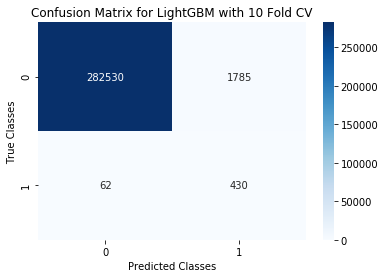

In [112]:
cm = pd.DataFrame([[TN, FP], [FN, TP]], index= [0,1], columns= [0,1])
plt.figure()
plt.title("Confusion Matrix for LightGBM with 10 Fold CV")
sns.heatmap(cm, cmap= "Blues", annot= True, fmt= "d")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

In [113]:
print ("% of Frauds predicted correctly=",(430/(62+430))*100)
print ("Average ROC AUC Score=",np.average(roc_auc_scores))

% of Frauds predicted correctly= 87.39837398373984
Average ROC AUC Score= 0.9326357484532487


With the New params, the average prediction rate is now 87.4% with ROC AUC score of 0.9326

**LightGBM Explanation**

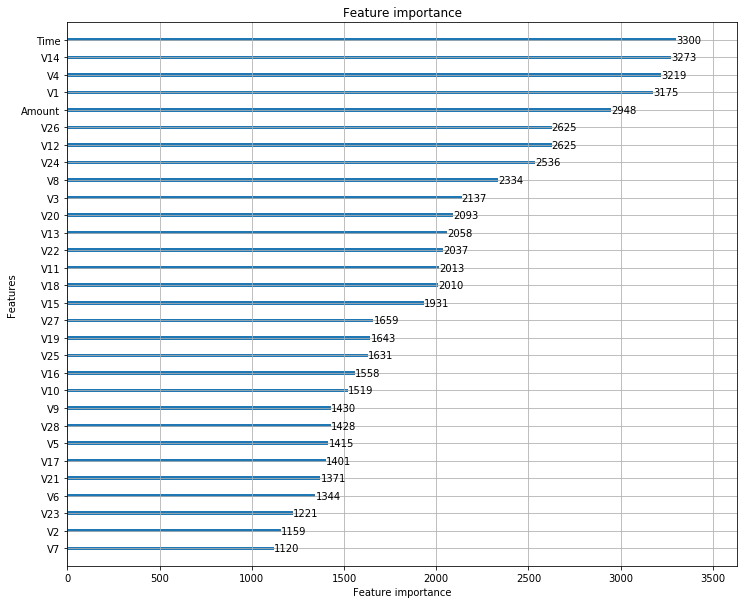

In [134]:
import lightgbm
lightgbm.plot_importance(lgb_model, figsize= (12, 10))

**Pipelining**

In [183]:
steps = [('scaler', StandardScaler()), ('classifier', LGBMClassifier(boosting_type = 'gbdt', num_leaves = 30, max_depth = 9,
                           n_estimators = 3500, objective = 'binary', min_split_gain = 0.1, min_child_weight = 0.01,
                           class_weight= {0:0.1, 1:1}, learning_rate = 0.007,
                           min_child_samples = 20, subsample=0.6, colsample_bytree = 0.9, reg_alpha = 0.1, reg_lambda = 0.7,
                           n_jobs = -1, verbose = -1))]

In [184]:
clf_pipeline = Pipeline(steps)

In [185]:
clf_pipeline['classifier']

LGBMClassifier(boosting_type='gbdt', class_weight={0: 0.1, 1: 1},
               colsample_bytree=0.9, importance_type='split',
               learning_rate=0.007, max_depth=9, min_child_samples=20,
               min_child_weight=0.01, min_split_gain=0.1, n_estimators=3500,
               n_jobs=-1, num_leaves=30, objective='binary', random_state=None,
               reg_alpha=0.1, reg_lambda=0.7, silent=True, subsample=0.6,
               subsample_for_bin=200000, subsample_freq=0, verbose=-1)

**Serialization** <br>
Model serialization can be done using Pickle or Joblib. The Joblib serialization API is well suited for Numpy arrays and hence serializing ML models with Joblib is a good choice. The serialized objects can be used across systems with same versions of packages involved in the training process during the time of model construction. So it is good to mention the build versions in the model file itself.

In [187]:
import sklearn
print ("Package versions at time of Piepline build:")
print("Sklearn:",sklearn.__version__[:6])
print("LightGBM:",lightgbm.__version__)

Package versions at time of Piepline build:
Sklearn: 0.22.2
LightGBM: 2.3.1


In [188]:
file_path = "model/ccfr_detector.joblib"
joblib.dump({'Scikit Learn version': sklearn.__version__[:6], 'LightGBM Version': lightgbm.__version__,
            'Predictor': lgb_model, 'Python Version' : '3.6'}, file_path)

['model/ccfr_detector.joblib']

**Final Inference Testing**<br>
We will save the test set from the non-scaled Data and use it for predictions using the dumped model.

In [151]:
X_1 = ccfr.drop('Class', axis= 1)
y_1 = ccfr['Class']
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size= 0.13, random_state= 48)

In [152]:
X_test.shape

(37025, 30)

In [153]:
y_test.shape

(37025,)

In [156]:
test_set = pd.concat([X_test, y_test], axis = 1)
test_set.to_csv("data/test_set.csv", index = False)

Loading test data and model for testing . . .

In [189]:
model = joblib.load("model/ccfr_detector.joblib")

In [190]:
print ("Required Scikit Learn ==",model['Scikit Learn version'])
print ("Required LightGBM ==",model['LightGBM Version'])
print ("Required Python ==",model['Python Version'])

Required Scikit Learn == 0.22.2
Required LightGBM == 2.3.1
Required Python == 3.6


In [203]:
classifier = model['Predictor']
test_data = pd.read_csv(r"data/test_set.csv")
test_X = test_data.drop('Class', axis = 1)
test_y = test_data['Class']

ROC AUC Score= 0.973823220082619
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36943
           1       0.37      0.95      0.53        82

    accuracy                           1.00     37025
   macro avg       0.69      0.97      0.77     37025
weighted avg       1.00      1.00      1.00     37025



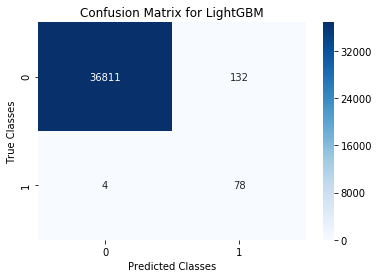

In [204]:
scaler = clf_pipeline['scaler']
test_X = scaler.fit_transform(test_X)
pred = classifier.predict(test_X)
print ("ROC AUC Score=",roc_auc_score(test_y, pred))
print ("Classification Report:")
print (classification_report(test_y, pred))
cm = pd.DataFrame(confusion_matrix(test_y, pred))
plt.figure()
plt.title("Confusion Matrix for LightGBM")
sns.heatmap(cm, cmap= "Blues", annot= True, fmt= "d")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

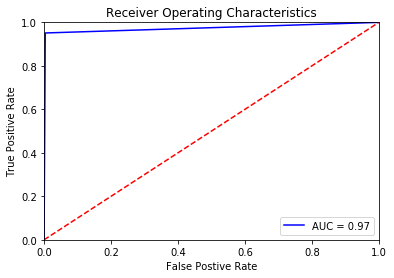

In [205]:
from sklearn.metrics import roc_curve
fpr , tpr, threshold = roc_curve(test_y, pred)
roc_auc = roc_auc_score(test_y, pred)

plt.title('Receiver Operating Characteristics')
plt.plot(fpr, tpr, 'b', label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = 'best')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")
plt.show()

Thus, with the final pipeline and saved model of the trained LGBMClassifier is able to achieve 95% fraud prediction rate at the cost of a meagre 132 non frauds being classified as fraud, with an ROC AUC score of 0.9738

**Thanks for Reading**